# Categorical Data with RFGBoost

A demonstration of using categorical data with RFGBoost.

We use Weight of Evidence (WOE) inside Random Forest to process categorical features.

Author: https://www.github.com/deburky

In [1]:
import pandas as pd

dataset = pd.read_csv("BankCaseStudyData.csv")

# Prepare features and labels
label = "Final_Decision"
dataset[label] = dataset[label].map({"Accept": 0, "Decline": 1})

num_features = [
    "Application_Score",
    "Bureau_Score",
    "Loan_Amount",
    "Time_with_Bank",
    "Time_in_Employment",
    "Loan_to_income",
    "Gross_Annual_Income",
]

cat_features = [
    "Loan_Payment_Frequency",
    "Residential_Status",
    "Cheque_Card_Flag",
    "Existing_Customer_Flag",
    "Home_Telephone_Number",
]

features = cat_features + num_features

ix_train = dataset["split"] == "Development"
ix_test = dataset["split"] == "Validation"

X_train = dataset.loc[ix_train, features]
y_train = dataset.loc[ix_train, label]
X_test = dataset.loc[ix_test, features]
y_test = dataset.loc[ix_test, label]

X_train.loc[:, cat_features] = X_train.loc[:, cat_features].astype(str).fillna("NA")
X_test.loc[:, cat_features] = X_test.loc[:, cat_features].astype(str).fillna("NA")

In [2]:
# Run CatBoost
import catboost as cb
from sklearn.metrics import roc_auc_score

cb_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    eval_metric="AUC",
    verbose=0,
)
cb_model.fit(X_train, y_train)
cb_pred = cb_model.predict_proba(X_test)[:, 1]
gini = 2 * roc_auc_score(y_test, cb_pred) - 1
print(f"CatBoost Gini: {gini:.4f}")
print(cb_pred.max())

CatBoost Gini: 0.8668
0.9586215372260694


In [3]:
# Run RFGBoost
from rfgboost import RFGBoost

# Configure and train our RandomForestGradientBoosting model
rf_params = {
    "n_estimators": 10,  # Number of trees in each Random Forest
    "max_depth": 4,
    "ccp_alpha": 0.0,  # Fraction of samples to use for each tree
    "random_state": 0,  # For reproducibility
}

rfgb_model = RFGBoost(
    n_estimators=10,  # Number of boosting iterations, same as CatBoost
    rf_params=rf_params,
    learning_rate=0.5,
    task="classification",
    cat_features=cat_features,
)

# Fit the model
rfgb_model.fit(X_train, y_train)
rfgb_pred = rfgb_model.predict(X_test)

# Calculate Gini coefficient (same as for CatBoost)
rfgb_gini = 2 * roc_auc_score(y_test, rfgb_pred) - 1
print(f"RFGBoost Gini: {rfgb_gini:.4f}")

print(rfgb_pred.max())

RFGBoost Gini: 0.8700
0.9620894244581686


In [4]:
cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Bureau_Score,30.336022
1,Application_Score,27.958736
2,Gross_Annual_Income,8.471903
3,Time_with_Bank,8.193415
4,Loan_Amount,5.616629
5,Cheque_Card_Flag,5.258204
6,Time_in_Employment,4.960649
7,Loan_to_income,4.687652
8,Residential_Status,3.152231
9,Home_Telephone_Number,1.192941


In [5]:
df_ = rfgb_model.get_feature_importance()
df_["Importance"] *= 100
df_

,Feature,Importance
0,Bureau_Score,25.883631
1,Application_Score,22.317877
2,Loan_Amount,10.440396
3,Time_with_Bank,10.303899
4,Gross_Annual_Income,10.102403
5,Loan_to_income,8.571234
6,Time_in_Employment,6.855964
7,Home_Telephone_Number,1.720956
8,Loan_Payment_Frequency,1.142988
9,Residential_Status,0.912476


DecisionTreeClassifier returns two class probabilities:

```python
array([[[0.50375   , 0.49625   ]],
       [[0.88084112, 0.11915888]],
       [[0.5412844 , 0.4587156 ]],
       [[0.61458333, 0.38541667]],
       [[0.        , 1.        ]]])
```

DecisionTreeRegressor returns a single value:

```python
array([[[-5.34658145e-03]],
       [[-5.84868227e+00]],
       [[-6.29343699e+00]],
       [[-7.33885572e+00]],
       [[-8.20020814e+00]]])
```

This is the reason why below we would see only Value and not Probabilities of class membership since the boosting model uses the DecisionTreeRegressor.

In [6]:
leaf_stats = rfgb_model.trees_to_dataframe()
display(leaf_stats.head())

,Round,Tree,NodeID,PathCondition,Samples,Value
0,0,0,3,Bureau_Score <= 804.5000 and Time_with_Bank <=...,5,-1.117436
1,0,0,5,Bureau_Score <= 804.5000 and Time_with_Bank <=...,328,7.939311
2,0,0,6,Bureau_Score <= 804.5000 and Time_with_Bank <=...,311,6.619400
3,0,0,9,Bureau_Score <= 804.5000 and Time_with_Bank > ...,478,6.235143
4,0,0,10,Bureau_Score <= 804.5000 and Time_with_Bank > ...,119,3.993332


If we want to understand probabilities of class membership we can pass *X* and *y* to the `trees_to_dataframe` method.

In [7]:
leaf_stats = rfgb_model.trees_to_dataframe(X_train, y_train)
display(leaf_stats.head())

,Round,Tree,NodeID,PathCondition,Samples,Value,Events,NonEvents,EventRate
0,0,0,3,Bureau_Score <= 804.5000 and Time_with_Bank <=...,5,-1.117436,2,6,0.250000
1,0,0,5,Bureau_Score <= 804.5000 and Time_with_Bank <=...,328,7.939311,458,99,0.822262
2,0,0,6,Bureau_Score <= 804.5000 and Time_with_Bank <=...,311,6.619400,339,152,0.690428
3,0,0,9,Bureau_Score <= 804.5000 and Time_with_Bank > ...,478,6.235143,517,228,0.693960
4,0,0,10,Bureau_Score <= 804.5000 and Time_with_Bank > ...,119,3.993332,88,90,0.494382


The model also allows to produce confidence intervals for the predicted values.

In [8]:
import pandas as pd

# Get predicted CIs and probabilities
ci = rfgb_model.predict_ci(X_test)
proba = rfgb_model.predict_proba(X_test)[:, 1]

# Build DataFrame with top 5
df_display = (
    pd.DataFrame(
        {
            "Lower CI": ci[:, 0],
            "Predicted Proba": proba,
            "Upper CI": ci[:, 1],
        }
    )
    .round(4)
    .head(5)
)

print(df_display)

   Lower CI  Predicted Proba  Upper CI
0    0.0324           0.0556    0.0939
1    0.0013           0.0031    0.0070
2    0.0315           0.0580    0.1046
3    0.0231           0.4161    0.9556
4    0.0025           0.0054    0.0116


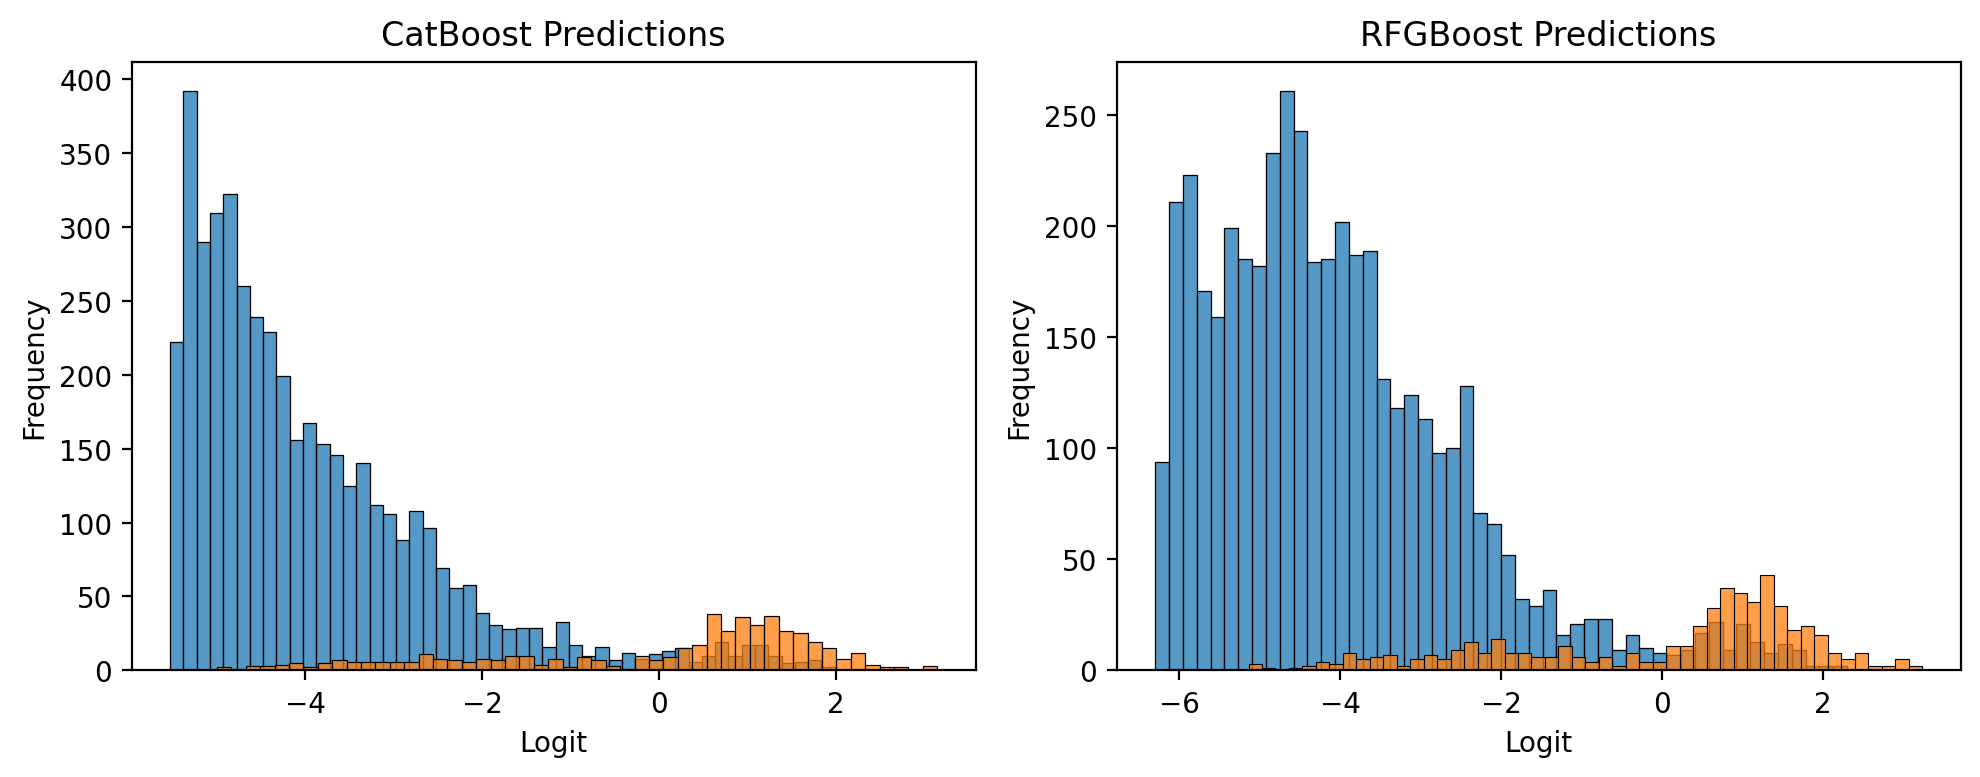

In [9]:
# plot histogram of cb_pred and rfgb_pred
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logit

%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# sns.histplot(cb_pred, bins='scott')
sns.histplot(logit(cb_pred[y_test == 0]), bins=50)
sns.histplot(logit(cb_pred[y_test == 1]), bins=50)
plt.title("CatBoost Predictions")
plt.xlabel("Logit")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
sns.histplot(logit(rfgb_pred[y_test == 0]), bins=50)
sns.histplot(logit(rfgb_pred[y_test == 1]), bins=50)
plt.title("RFGBoost Predictions")
plt.xlabel("Logit")
plt.ylabel("Frequency")
plt.tight_layout()

## Uncertainty

We can use built-in uncertainty quantification from random forest.

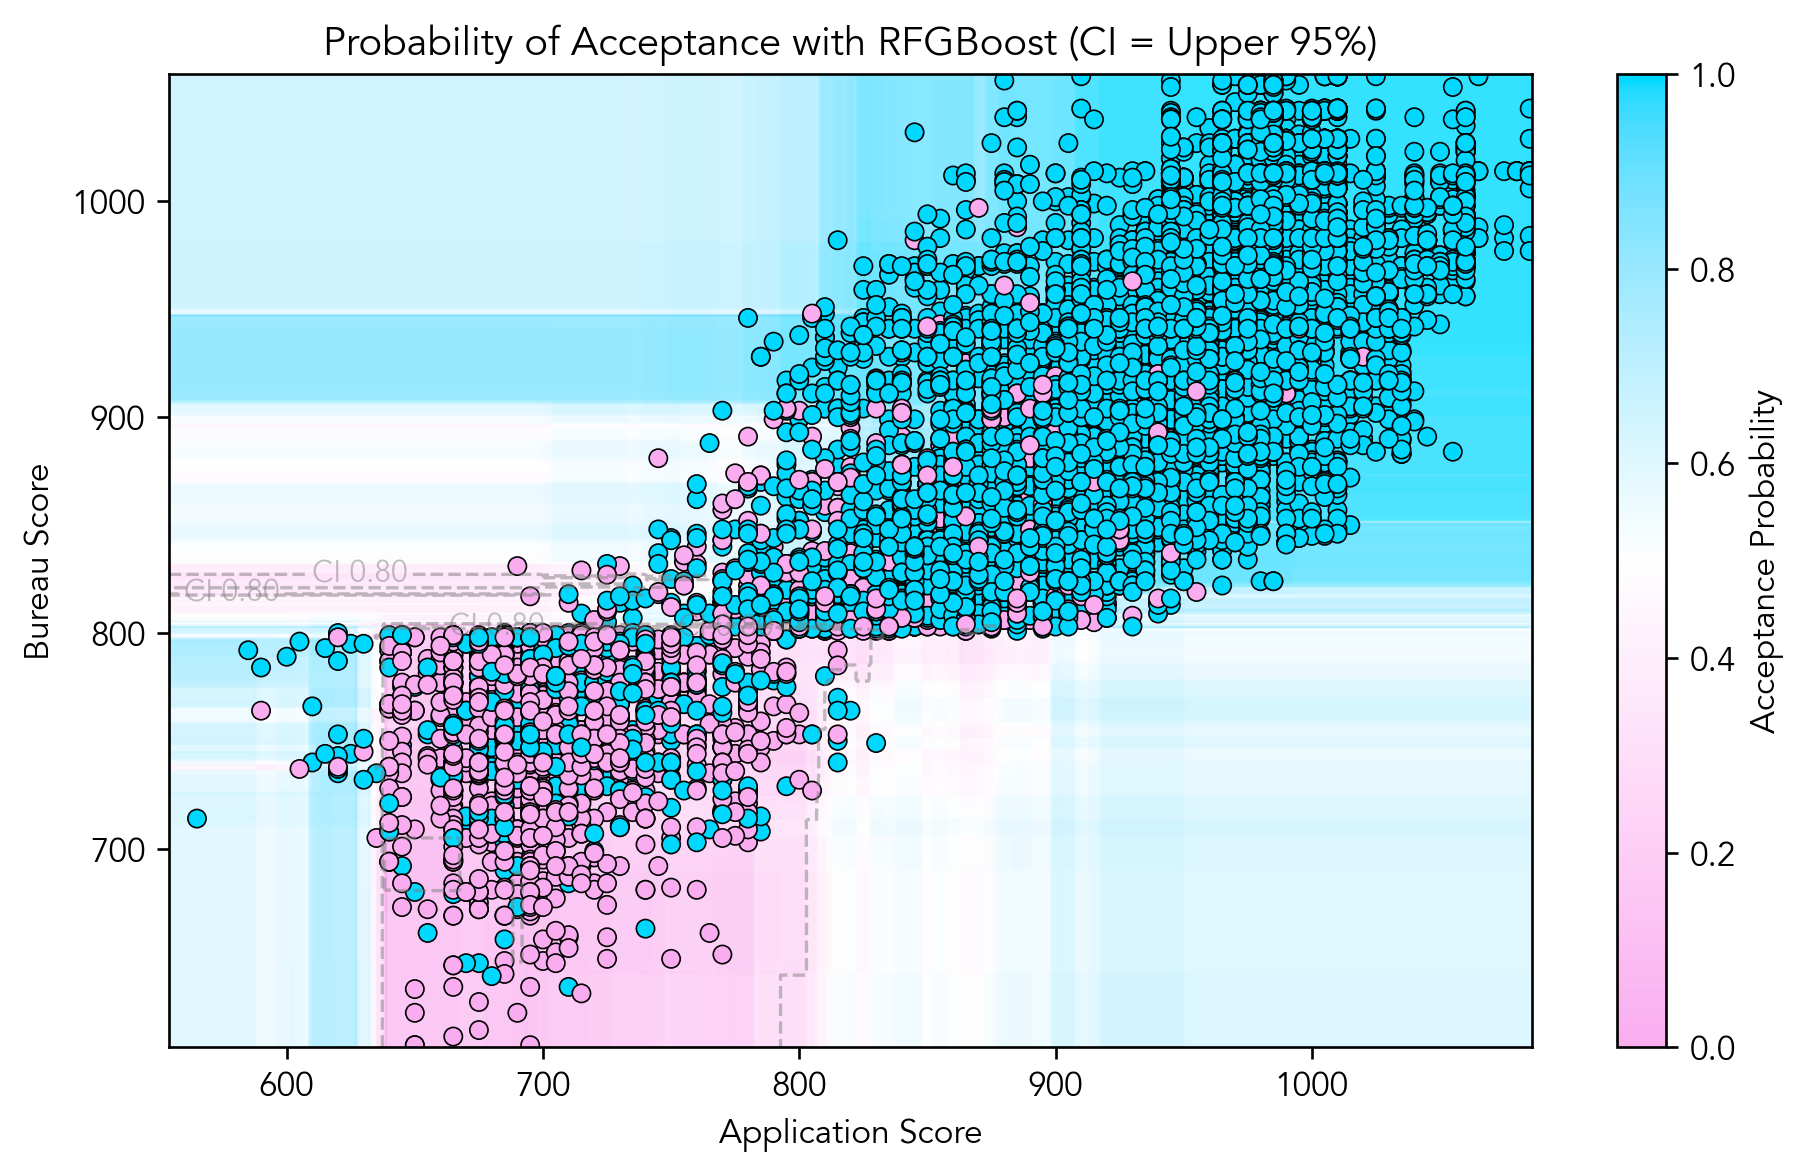

In [10]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LightSource
from rfgboost import RFGBoost
from sklearn.model_selection import train_test_split

cmap2 = cmaps.cet_d_cwm_8_r

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"

# Load dataset
dataset = pd.read_csv("BankCaseStudyData.csv")
label = "Final_Decision"

X = dataset[["Application_Score", "Bureau_Score"]]
y = dataset[label].map({"Accept": 1, "Decline": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
model = RFGBoost(
    n_estimators=5,
    rf_params={"n_estimators": 10, "max_depth": 5},
    learning_rate=0.1,
    task="classification",
)
model.fit(X_train, y_train)

# Meshgrid
x_min, x_max = X["Application_Score"].min() - 1, X["Application_Score"].max() + 1
y_min, y_max = X["Bureau_Score"].min() - 1, X["Bureau_Score"].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(grid, columns=["Application_Score", "Bureau_Score"])

# Predictions and CIs
Z_mean = model.predict(grid_df).reshape(xx.shape)
ci = model.predict_ci(grid_df, alpha=0.05)
Z_upper = ci[:, 1].reshape(xx.shape)

# Light source shading
ls = LightSource(azdeg=315, altdeg=45)
shaded_surface = ls.shade(Z_mean, cmap=cmap2, vert_exag=3, blend_mode="soft")


# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.imshow(
    shaded_surface,
    extent=(x_min, x_max, y_min, y_max),
    origin="lower",
    aspect="auto",
    cmap=cmap2,
    alpha=0.8,
)

# Confidence interval upper bounds as terrain ridges
cont = ax.contour(
    xx,
    yy,
    Z_upper,
    levels=1,
    colors="grey",
    linewidths=1,
    alpha=0.5,
    linestyles="dashed",
)
ax.clabel(cont, inline=True, fontsize=9, fmt="CI %.2f")

# Training data overlay
scatter = ax.scatter(
    X_train["Application_Score"],
    X_train["Bureau_Score"],
    c=y_train,
    cmap=cmap2,
    edgecolor="k",
    linewidth=0.5,
    alpha=1.0,
    s=30,
)

Z_lower = ci[:, 0].reshape(xx.shape)
Z_width = Z_upper - Z_lower

uncertainty_overlay = ax.contourf(xx, yy, Z_width, levels=10, cmap="Greys", alpha=0)
ax.set_xlabel("Application Score")
ax.set_ylabel("Bureau Score")
ax.set_title("Probability of Acceptance with RFGBoost (CI = Upper 95%)")
plt.colorbar(scatter, ax=ax, label="Acceptance Probability")
plt.tight_layout()
plt.show()